In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from typing import Any, BinaryIO, List, Optional, Tuple, Union
import math


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)



In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [ ]:
def gradient_penalty(critic, labels, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NUM_CLASSES = 10
GEN_EMBEDDING = 100
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10


In [ ]:
device

'cuda'

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)


In [ ]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)


In [ ]:
# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0



In [ ]:
def my_make_grid(tensor,
                 nrow: int = 8,
                 padding: int = 2,
                 normalize: bool = False,
                 scale_each: bool = False,
                 value_range: Optional[Tuple[int, int]] = None) -> torch.tensor:

    if normalize is True:
        tensor = tensor.clone()  # avoid modifying tensor in-place
        if value_range is not None and not isinstance(value_range, tuple):
            raise TypeError("value_range has to be a tuple (min, max) if specified. min and max are numbers")

        def norm_ip(img, low, high):
            img.clamp_(min=low, max=high)
            img.sub_(low).div_(max(high - low, 1e-5))

        def norm_range(t, value_range):
            if value_range is not None:
                norm_ip(t, value_range[0], value_range[1])
            else:
                norm_ip(t, float(t.min()), float(t.max()))

        if scale_each is True:
            for t in tensor:  # loop over mini-batch dimension
                norm_range(t, value_range)
        else:
            norm_range(tensor, value_range)

    nmaps = tensor.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.size(2) + padding), int(tensor.size(3) + padding)
    num_channels = tensor.size(1)
    grid = tensor.new_full((num_channels, height * ymaps + padding, width * xmaps + padding), 0)
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break

            tmp = tensor[k].clone()
            # Tensor.copy_() is a valid method but seems to be missing from the stubs
            # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.copy_
            grid.narrow(1, y * height + padding, height - padding).narrow(  # type: ignore[attr-defined]
                2, x * width + padding, width - padding
            ).copy_(tmp)
            k = k + 1
    return grid


In [ ]:
gen.train()
critic.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, labels) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, labels, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = my_make_grid(real[:32], normalize=True)
                img_grid_fake = my_make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1


 11%|█         | 101/938 [00:17<02:43,  5.13it/s]

Epoch [0/100] Batch 100/938                   Loss D: -5.7930, loss G: 63.2343


 21%|██▏       | 201/938 [00:35<02:25,  5.06it/s]

Epoch [0/100] Batch 200/938                   Loss D: -4.9446, loss G: 61.8365


 32%|███▏      | 301/938 [00:52<02:03,  5.17it/s]

Epoch [0/100] Batch 300/938                   Loss D: -6.2180, loss G: 67.8010


 43%|████▎     | 401/938 [01:10<01:43,  5.21it/s]

Epoch [0/100] Batch 400/938                   Loss D: -5.1481, loss G: 63.6492


 53%|█████▎    | 501/938 [01:27<01:24,  5.19it/s]

Epoch [0/100] Batch 500/938                   Loss D: -5.4015, loss G: 58.8895


 64%|██████▍   | 601/938 [01:45<01:05,  5.12it/s]

Epoch [0/100] Batch 600/938                   Loss D: -3.7343, loss G: 64.5998


 75%|███████▍  | 701/938 [02:02<00:45,  5.16it/s]

Epoch [0/100] Batch 700/938                   Loss D: -4.5433, loss G: 61.3009


 85%|████████▌ | 801/938 [02:19<00:26,  5.18it/s]

Epoch [0/100] Batch 800/938                   Loss D: -3.4892, loss G: 58.9134


 96%|█████████▌| 901/938 [02:37<00:07,  4.79it/s]

Epoch [0/100] Batch 900/938                   Loss D: -4.9765, loss G: 63.2905


  5%|▌         | 50/938 [00:08<02:33,  5.77it/s]


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt


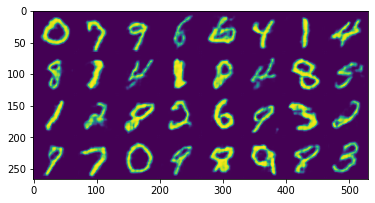

In [ ]:
plt.imshow(img_grid_fake[0].to('cpu'))

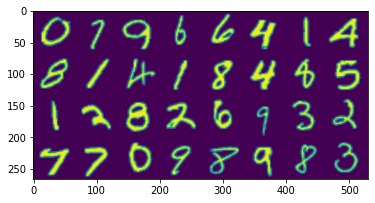

In [ ]:
plt.imshow(img_grid_real[0].to('cpu'))